<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 101 (delta 48), reused 57 (delta 22), pack-reused 0
Receiving objects: 100% (101/101), 5.08 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 96
#Number of epochs
num_epochs = 120
#Number of layers
num_layers = 1
#Number of neurons
num_neur=150 


In [4]:
cd Neutron_Reflect/

/content/Neutron_Reflect


In [5]:
#Stored those numpy arrays
data_path = './data/'
sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

In [6]:
sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype

((5942, 2, 96), (5942, 3), dtype('float64'), dtype('float64'))

In [7]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [8]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 96) (4753, 3) (594, 2, 96) (594, 3) (595, 2, 96) (595, 3)


In [9]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [10]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [11]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [12]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/120 	 train loss 0.07711923122406006 	 val loss 0.040409449487924576
EPOCH 2/120 	 train loss 0.007162649184465408 	 val loss 0.00021330559684429318
EPOCH 3/120 	 train loss 0.00017723580822348595 	 val loss 0.0001869194966275245
EPOCH 4/120 	 train loss 0.00015381533012259752 	 val loss 0.00017943607235793024
EPOCH 5/120 	 train loss 0.00013180966197978705 	 val loss 0.00013299354759510607
EPOCH 6/120 	 train loss 0.00011402597738197073 	 val loss 0.0001377138978568837
EPOCH 7/120 	 train loss 0.00010933054727502167 	 val loss 0.0001286974729737267
EPOCH 8/120 	 train loss 0.0001027660327963531 	 val loss 0.00013228160969447345
EPOCH 9/120 	 train loss 0.00010044950613519177 	 val loss 0.00011396459740353748
EPOCH 10/120 	 train loss 9.551112452754751e-05 	 val loss 9.986607619794086e-05
EPOCH 11/120 	 train loss 9.290119487559423e-05 	 val loss 0.0001315664849244058
EPOCH 12/120 	 train loss 9.227069676853716e-05 	 val loss 0.00010356795246480033
EPOCH 13/120 	 train loss 9.0

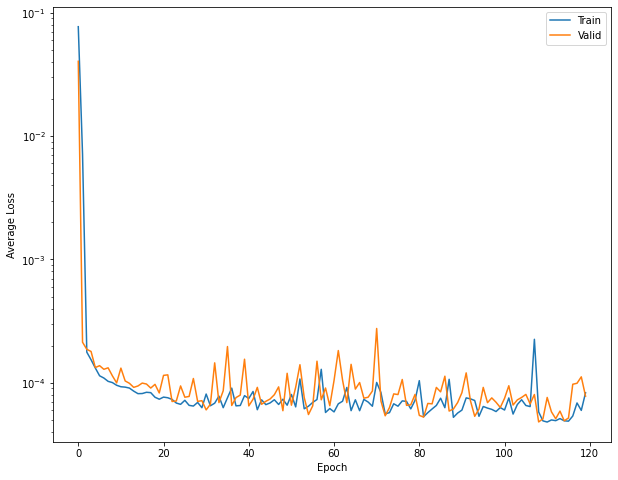

In [13]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 5.517984027392231e-05
For image 1, the loss = 4.041171632707119e-05
For image 2, the loss = 3.9666334487264976e-05
For image 3, the loss = 4.184416320640594e-05
For image 4, the loss = 4.874208752880804e-05
For image 5, the loss = 5.504091313923709e-05
For image 6, the loss = 0.00022523649386130273
For image 7, the loss = 4.26921178586781e-05
For image 8, the loss = 4.288569834898226e-05
For image 9, the loss = 6.795617809984833e-05


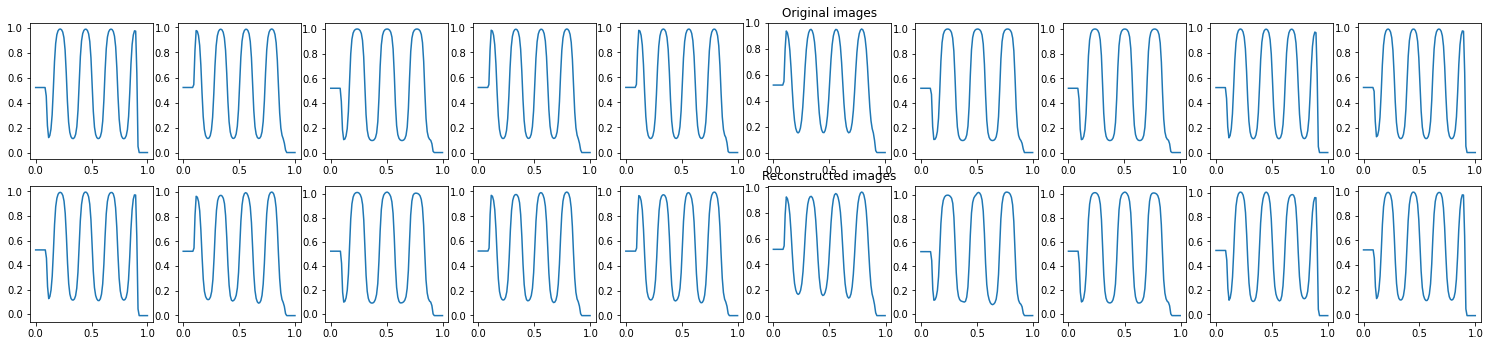

In [14]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([0.4528, 3.4293, 1.4080])
tensor([2.3314, 0.6828, 2.6703])


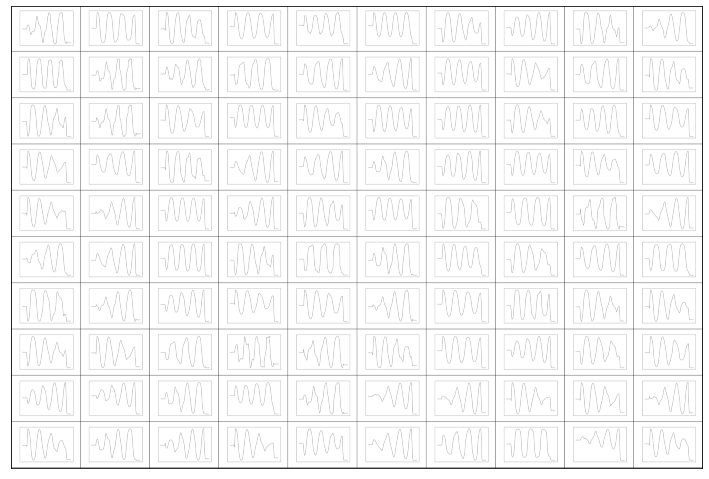

In [15]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [16]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  print(label_index)

label0
label1
label2


In [17]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,label0,label1,label2
0,-1.097890,4.304532,-2.286959,0.107,0.278,0.00778
1,3.378972,3.005797,-0.480000,0.109,0.525,0.48302
2,1.719879,2.773396,3.981721,0.0605,-0.075,0.44579
3,-3.154564,4.051979,2.992623,0.174,-0.557,-0.37671
4,-3.213311,4.080051,2.855748,0.192,-0.207,-0.41404
...,...,...,...,...,...,...
4748,1.819952,2.675955,4.545717,0.138,-0.561,0.20354
4749,-2.895740,4.036832,2.817890,0.0526,-0.554,-0.51615
4750,-1.150819,4.328070,-2.322595,0.127,0.446,-0.37336
4751,-3.200454,4.066795,2.894437,0.147,-0.139,-0.2267


In [18]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 192]) torch.Size([4753, 192]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 192]) torch.Size([594, 192]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 192]) torch.Size([595, 192]) torch.Size([595, 3]) torch.Size([595, 3])


In [19]:
# #Saving encoder and decoder 
# torch.save(encoder.state_dict(),"./encoder.pt")
# torch.save(decoder.state_dict(),"./decoder.pt")

In [20]:
# #Reloading the encoder and decoderen
# encoder.load_state_dict(torch.load("./encoder.pt"))
# decoder.load_state_dict(torch.load("./decoder.pt"))

In [21]:
num_epochs = 1600
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [22]:
# #Running the MLP
# ### Define the loss function 
# loss_fn = torch.nn.MSELoss()

# ### Define the learning rate
# lr= 0.001

# ### Set the random seed for reproducible results
# torch.manual_seed(0)

# #model 
# model = mlp.MLP(dim=d,nlabel=nlabel)
# params_to_optimize = [
#     {'params': model.parameters()}
# ]

# #Define the optimizer
# optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# #Checking the device
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

In [23]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (pepe): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [24]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/1600 	 train loss 0.04443374276161194 	 val loss 0.022178523242473602
EPOCH 2/1600 	 train loss 0.023111442103981972 	 val loss 0.0201334897428751
EPOCH 3/1600 	 train loss 0.020662296563386917 	 val loss 0.024226495996117592
EPOCH 4/1600 	 train loss 0.020016508176922798 	 val loss 0.022745493799448013
EPOCH 5/1600 	 train loss 0.01977941021323204 	 val loss 0.020479200407862663
EPOCH 6/1600 	 train loss 0.01903749816119671 	 val loss 0.018045078963041306
EPOCH 7/1600 	 train loss 0.017946487292647362 	 val loss 0.01764284074306488
EPOCH 8/1600 	 train loss 0.017738400027155876 	 val loss 0.017613692209124565
EPOCH 9/1600 	 train loss 0.017979344353079796 	 val loss 0.018452635034918785
EPOCH 10/1600 	 train loss 0.017871322110295296 	 val loss 0.017888329923152924
EPOCH 11/1600 	 train loss 0.017174147069454193 	 val loss 0.01694260910153389
EPOCH 12/1600 	 train loss 0.016541214659810066 	 val loss 0.017920348793268204
EPOCH 13/1600 	 train loss 0.016365937888622284 	 val lo

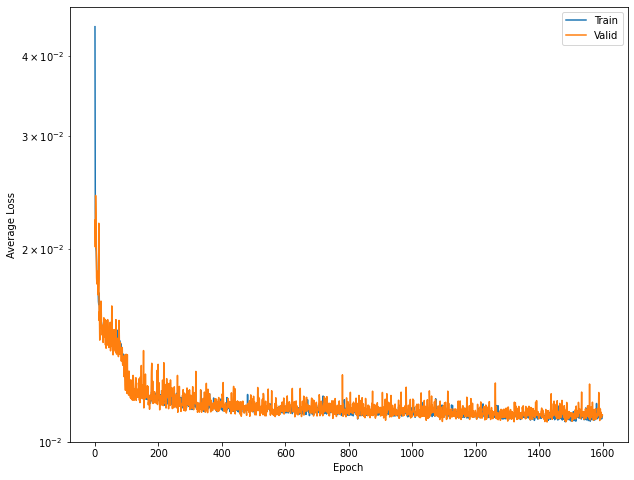

In [25]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [26]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.158666,0.200216,0.413225,0.13,0.237,0.44555
1,0.062449,-0.327993,0.253803,0.0516,-0.394,0.30381
2,0.143439,0.206862,-0.299404,0.172,0.198,-0.16525
3,0.158958,0.208586,0.404958,0.13,0.315,0.53161
4,0.158345,0.304231,0.310260,0.142,0.502,0.47217
...,...,...,...,...,...,...
590,0.146979,0.388319,-0.286745,0.136,0.302,-0.10389
591,0.132812,0.351177,-0.294410,0.109,0.343,-0.18935
592,0.143305,0.185810,-0.299242,0.182,0.159,-0.13201
593,0.066159,0.448077,-0.148006,0.0758,0.311,-0.11016


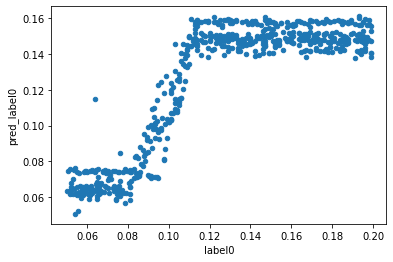

In [27]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

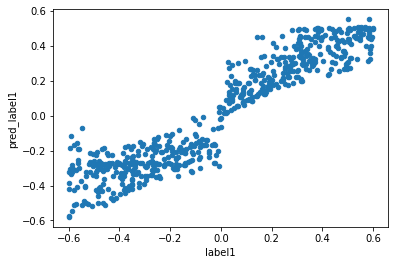

In [28]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

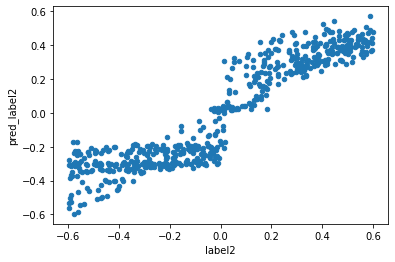

In [29]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [30]:
#Saving data into GitHub

# torch.save(train_latent_var,os.path.join(data_path,'train_latent_var.pt'))
# torch.save(train_latent_var,'train_labels_var.pt')

# torch.save(valid_latent_var,'valid_latent_var.pt')
# torch.save(valid_latent_var,'valid_labels_var.pt')

# torch.save(test_latent_var,'test_latent_var.pt')
# torch.save(test_latent_var,'test_labels_var.pt')


# torch.save(mlp_train_loader,'mlp_train_loader.pth')
# torch.save(mlp_valid_loader,'mlp_valid_loader.pth')
# torch.save(mlp_test_loader,'mlp_test_loader.pth')

# !mv mlp_train_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_valid_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_test_loader.pth /content/drive/MyDrive/neutron_reflectivity/

# torch.save(mlp_test_dataset,'mlp_test_dataset.pth')
# !mv mlp_test_dataset.pth /content/drive/MyDrive/neutron_reflectivity/

# #Saving also the pandas dataframe for the encoded sample

# #Having issues with the way a saved .csv and loaded one look like. 
# # df_encoded_samples.to_csv('encoded.csv', sep ='\t')
# # !mv encoded.csv /content/drive/MyDrive/neutron_reflectivity/

# #Using pickle instead.
# df_encoded_samples.to_pickle('df_encoded_samples.pkl')
# !mv df_encoded_samples.pkl /content/drive/MyDrive/neutron_reflectivity/